Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


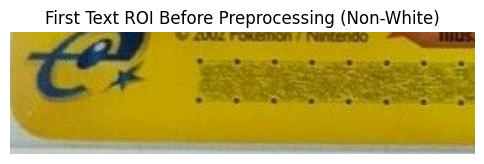

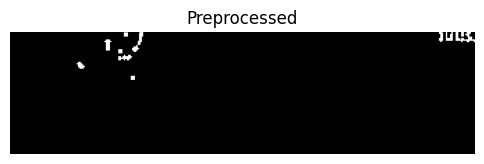

OCR result: []


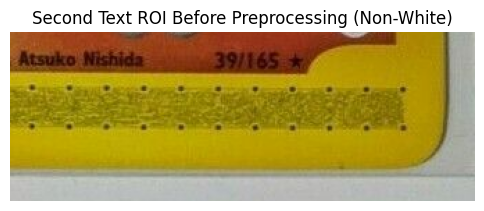

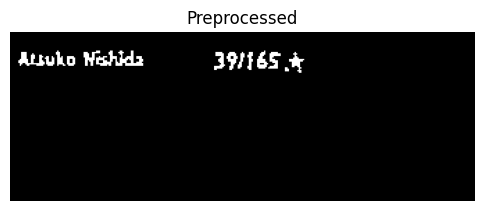

OCR result: ['AJuko Hahd', '39/165 4']


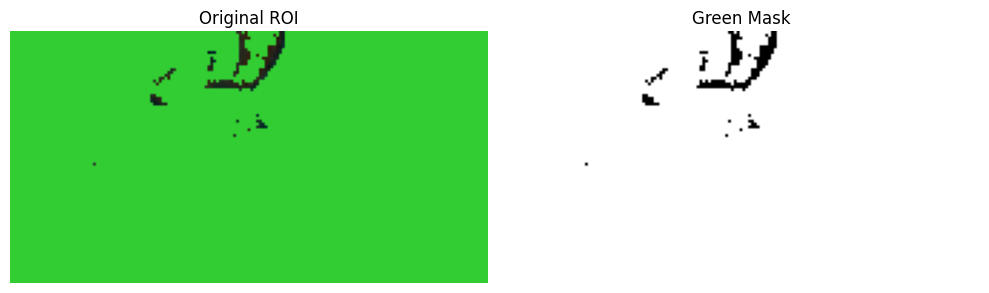

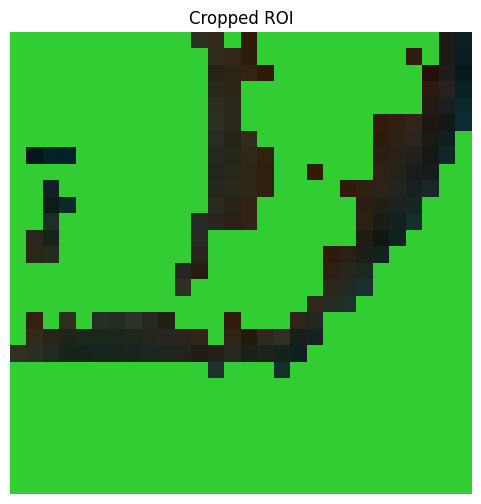

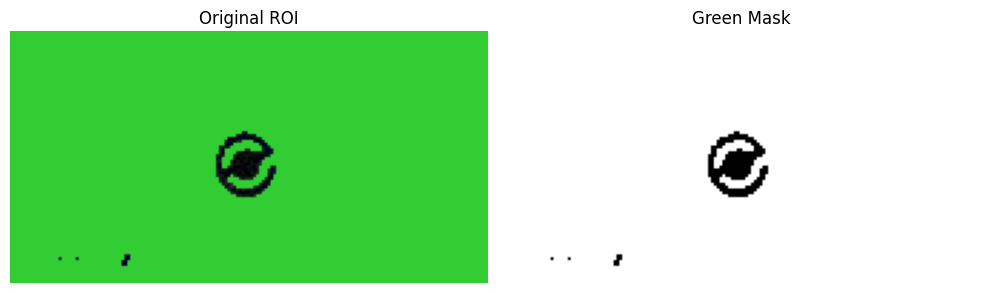

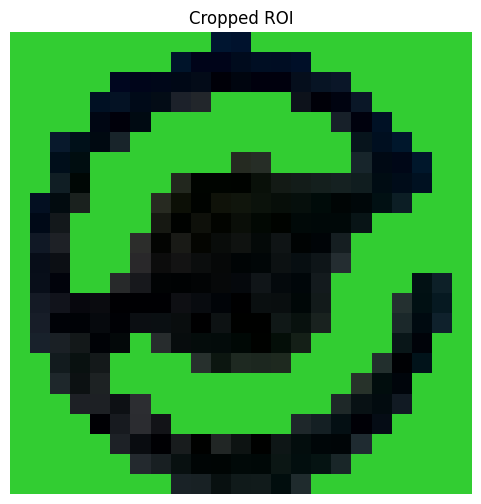

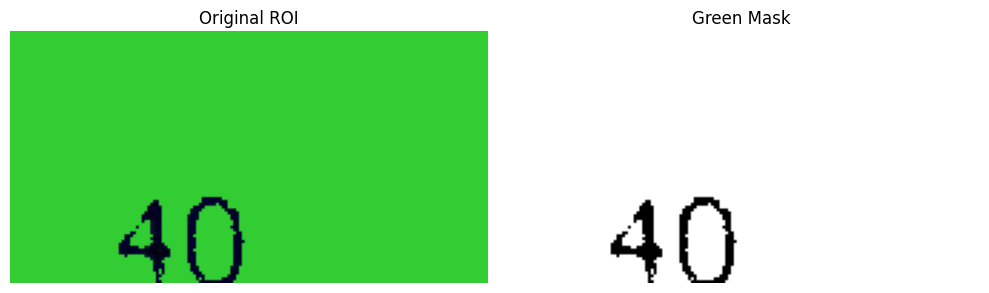

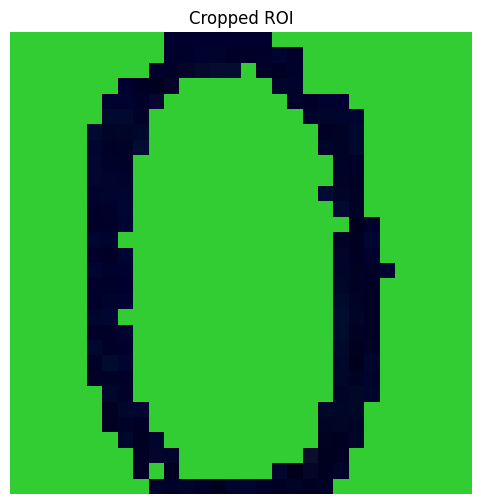

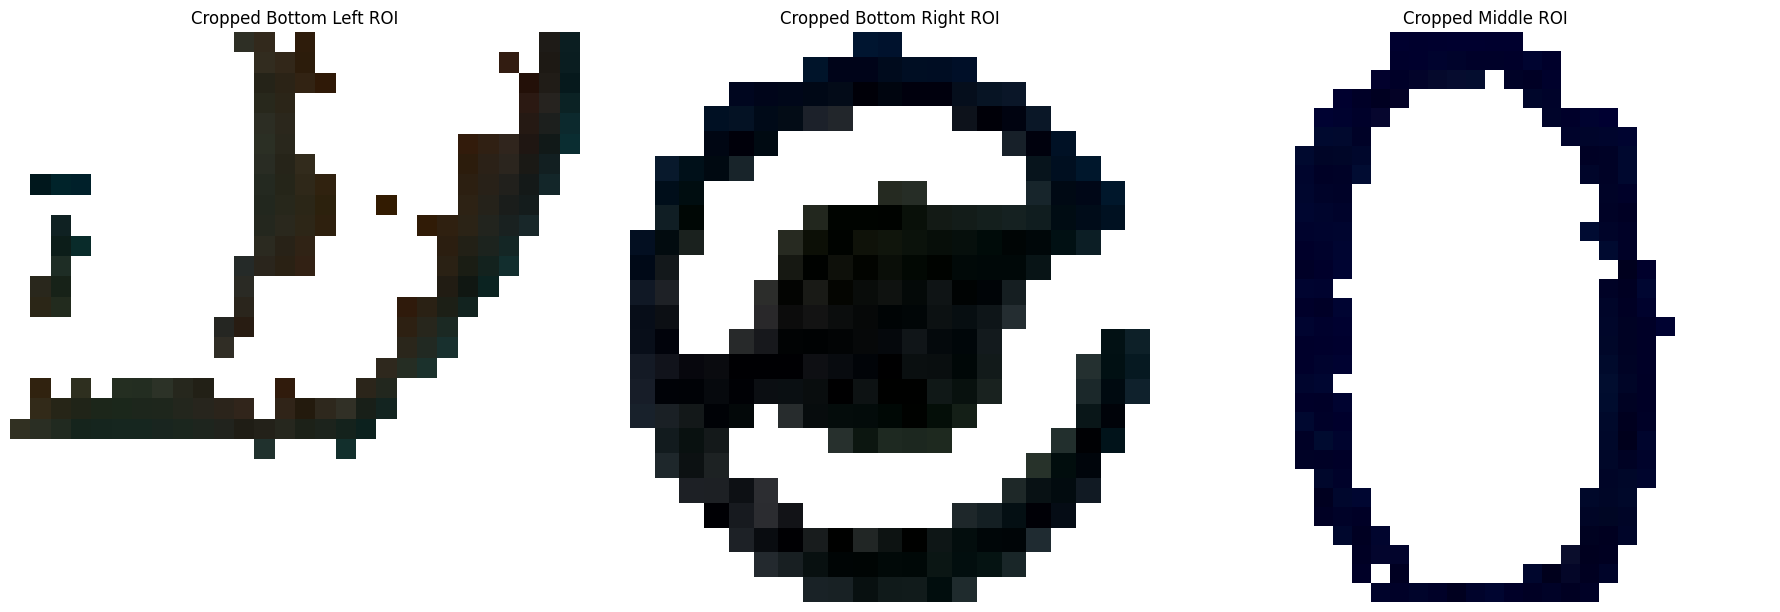

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Model Prediction for Bottom Left: Class: Guardians Rising, Confidence: 1.0000
Top 3 Class Names for Bottom Left: ['Guardians Rising', 'Cosmic Eclipse', 'Secret Wonders']
Model Prediction for Middle: Class: Secret Wonders, Confidence: 1.0000
Top 3 Class Names for Middle: ['Secret Wonders', "Champion's Path", 'Phantom Forces']
Model Prediction for Bottom Right: Class: Majestic Dawn, Confidence: 1.0000
Top 3 Class Names for Bottom Right: ['Majestic Dawn', 'Pokémon Rumble', 'Celestial Storm']


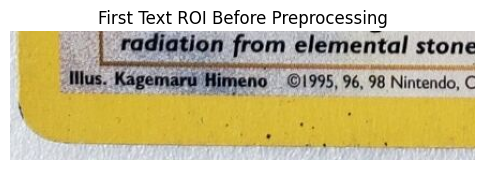

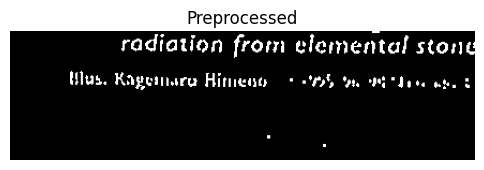

OCR result: ['radiation from elcmental stone', 'Hlus', 'Kagetllwru Hirneutr']


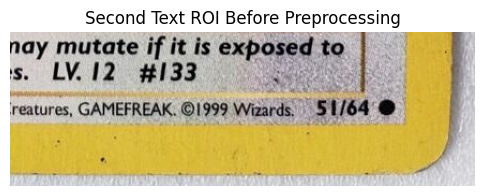

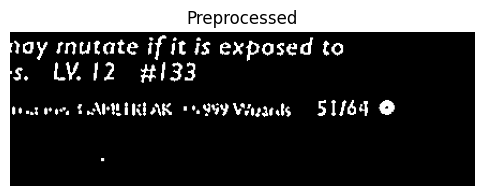

OCR result: ['ay rnutate if it is exposed to', 'LV: 12', '#133', "Mimak '95y Vxuat Is", '51/64 0']


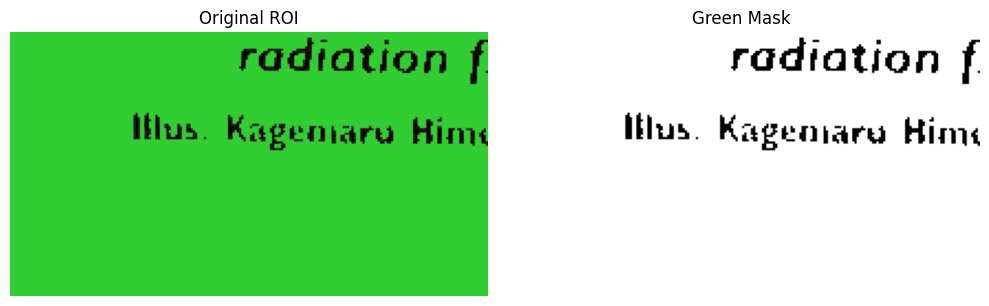

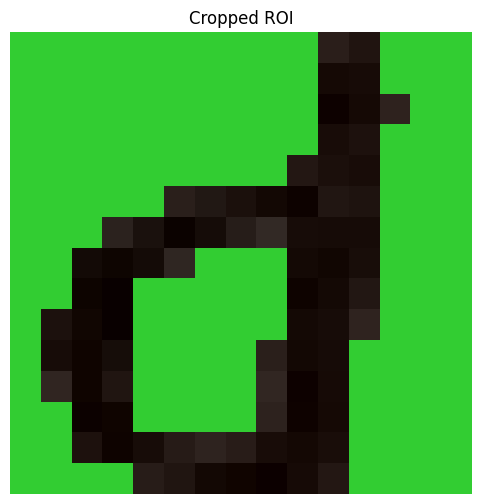

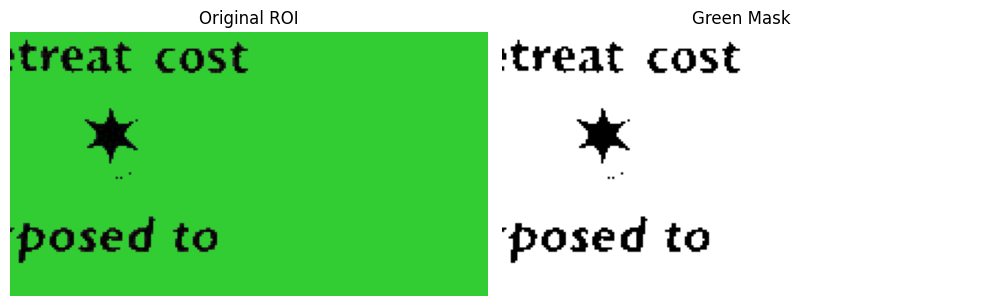

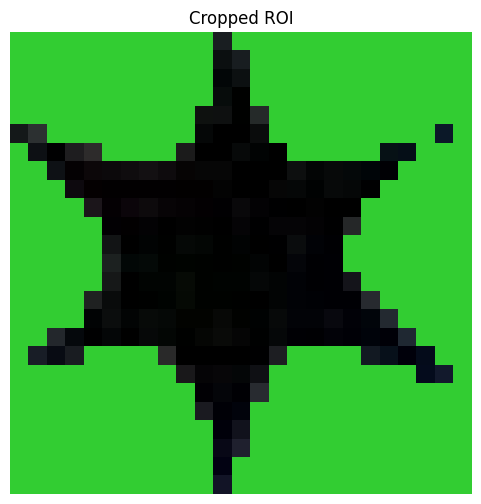

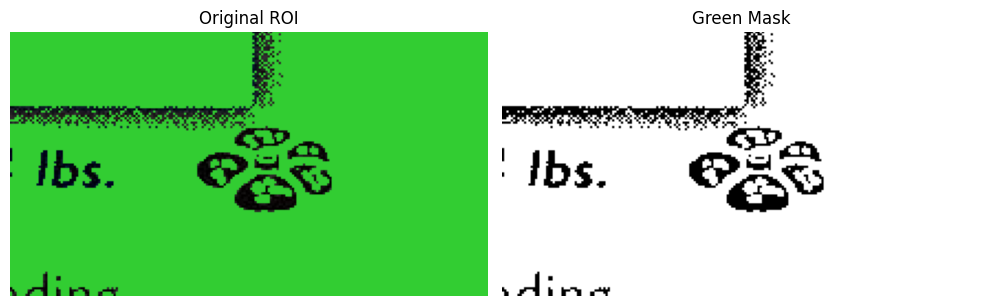

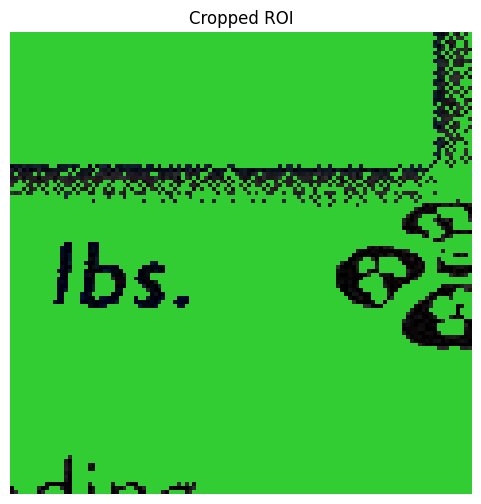

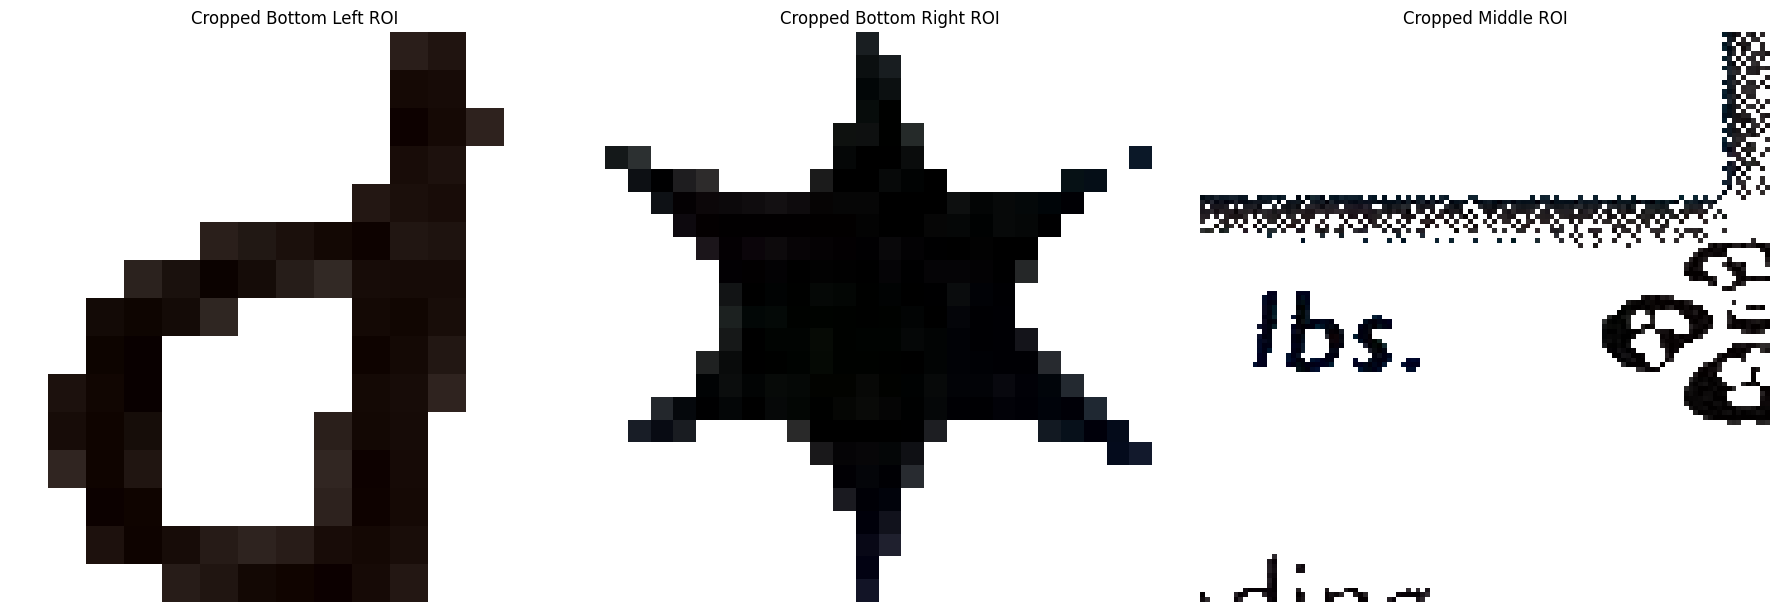

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Model Prediction for Bottom Left: Class: Next Destinies, Confidence: 1.0000
Top 3 Class Names for Bottom Left: ['Next Destinies', 'Secret Wonders', 'Dark Explorers']
Model Prediction for Bottom Right: Class: Fates Collide, Confidence: 1.0000
Top 3 Class Names for Bottom Right: ['Fates Collide', 'XY', 'Dragon Vault']
Model Prediction for Middle: Class: Kalos Starter Set, Confidence: 1.0000
Top 3 Class Names for Middle: ['Kalos Starter Set', 'XY', 'Evolving Skies']


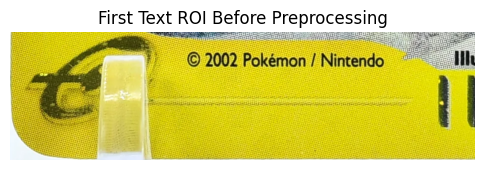

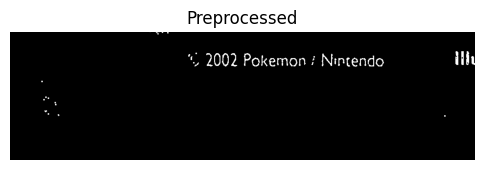

OCR result: ['2002 Pokemon', 'Ninrendo']


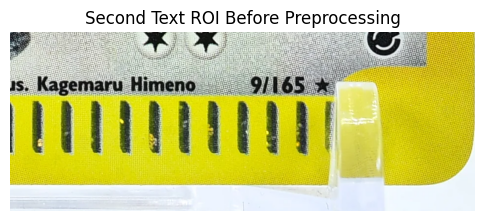

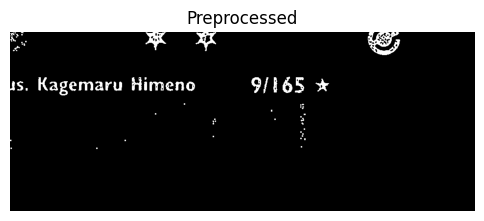

OCR result: ['JS,', 'Kagemaru Himeno', '9/165']


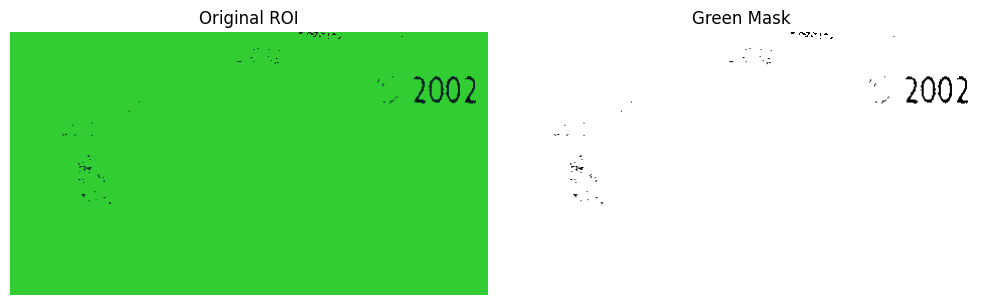

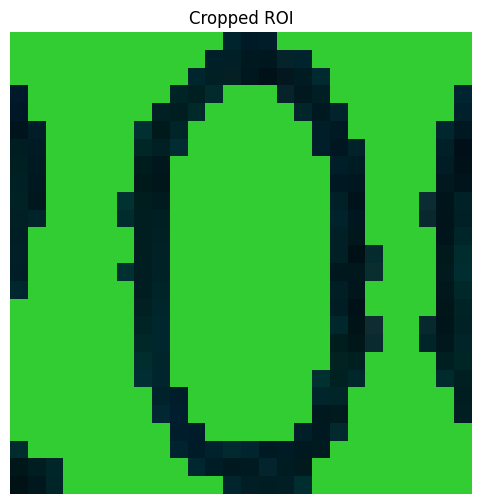

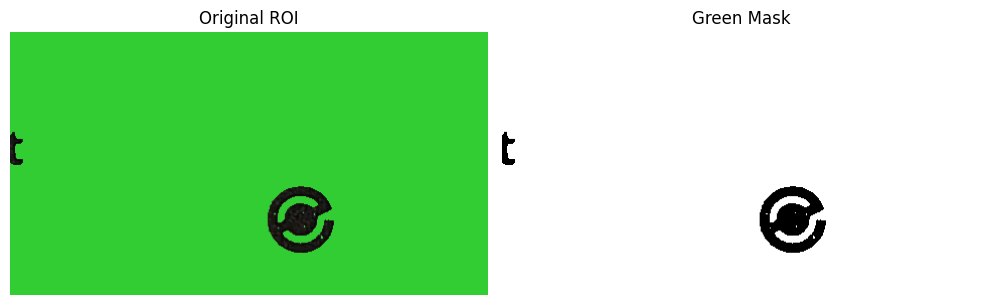

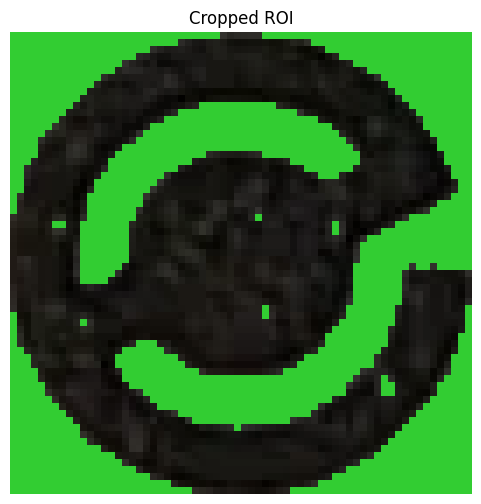

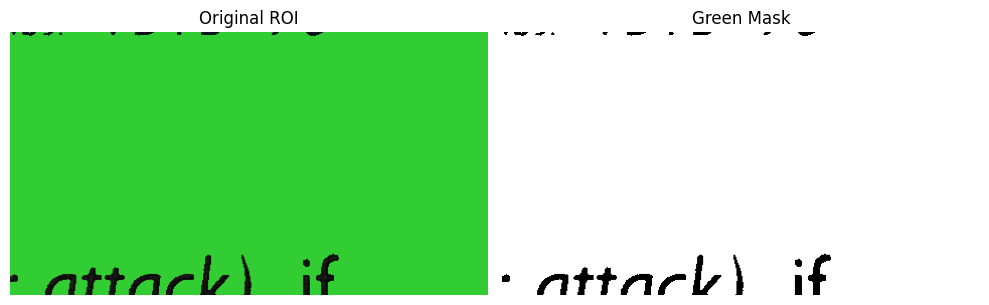

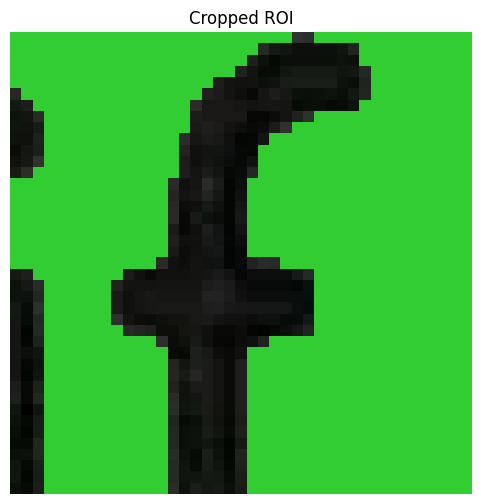

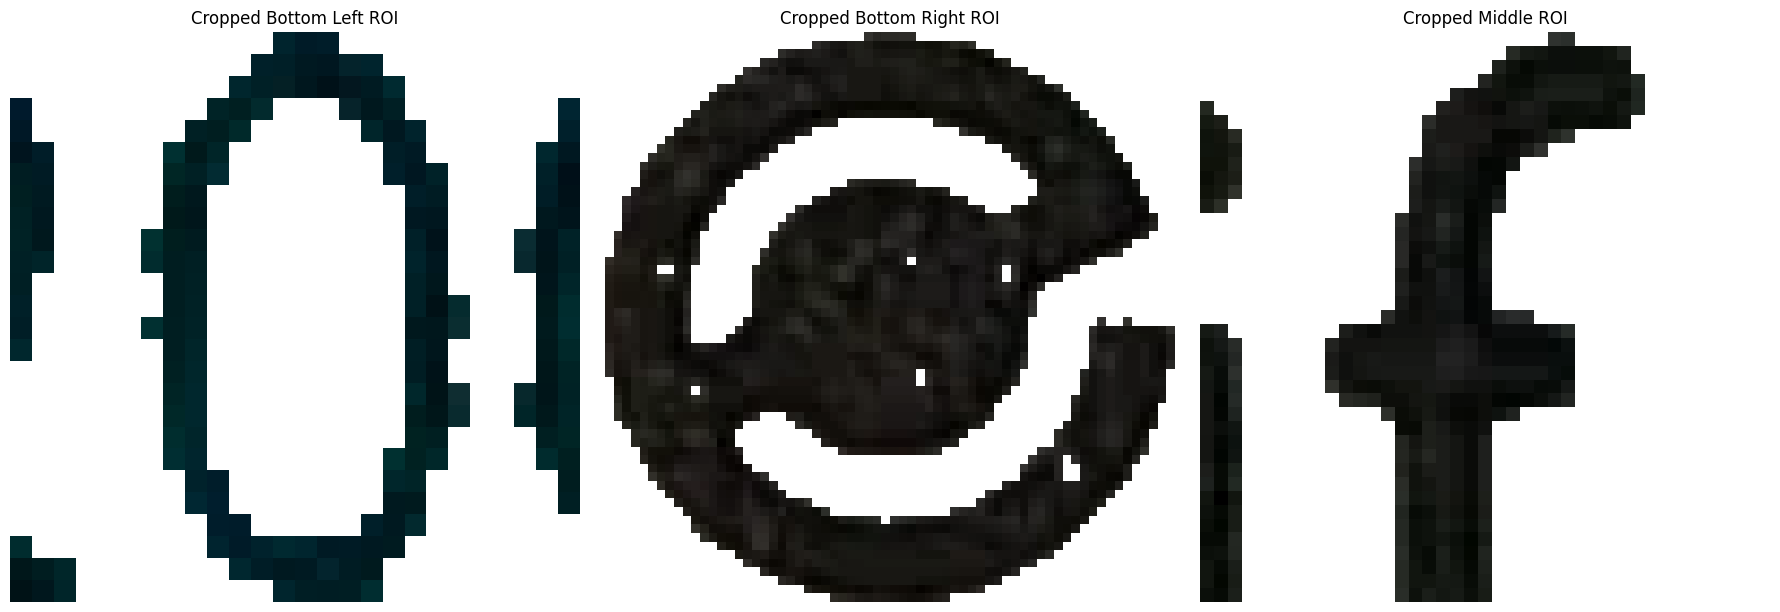

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Model Prediction for Bottom Right: Class: McDonald's Collection 2016, Confidence: 1.0000
Top 3 Class Names for Bottom Right: ["McDonald's Collection 2016", 'Plasma Freeze', 'Majestic Dawn']
Model Prediction for Middle: Class: Rising Rivals, Confidence: 1.0000
Top 3 Class Names for Middle: ['Rising Rivals', 'Black & White', 'Evolving Skies']
Model Prediction for Bottom Left: Class: Rising Rivals, Confidence: 0.9945
Top 3 Class Names for Bottom Left: ['Rising Rivals', 'Secret Wonders', 'Cosmic Eclipse']


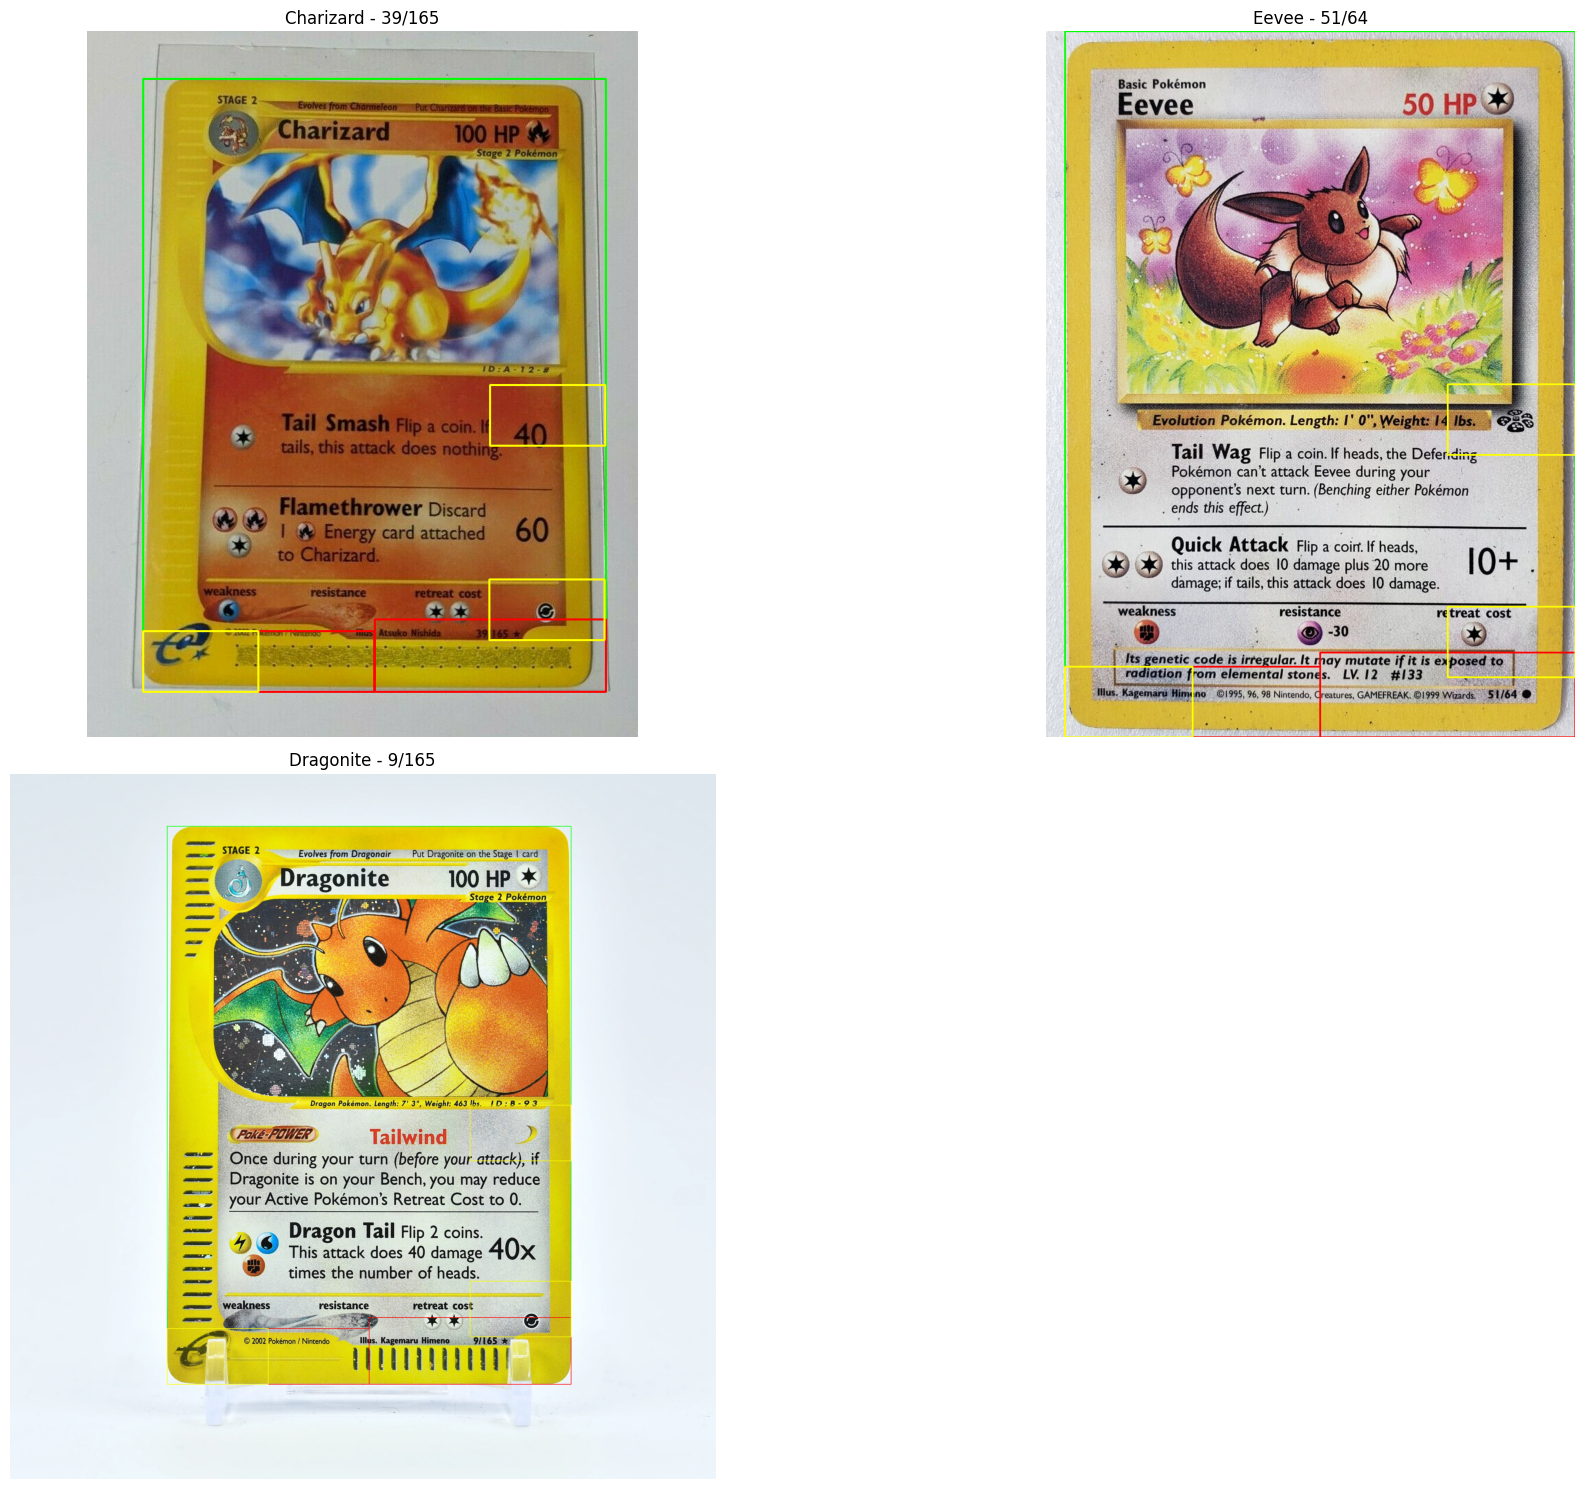

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import easyocr
from PIL import Image
from collections import Counter
import re
from tensorflow.keras.models import load_model
import json

# Load the saved model
model = load_model(r"C:\Users\Jimmy\Desktop\final-project\PokemonTCG\models\model06.keras")

# Load the class names (saved class indices from JSON file)
with open(r'C:\Users\Jimmy\Desktop\final-project\class_indices.json', 'r') as f:
    class_indices = json.load(f)

# Reverse the dictionary to map numeric labels to class names
class_names = {v: k for k, v in class_indices.items()}

# Initialize EasyOCR reader (use 'en' for English)
reader = easyocr.Reader(['en'])

# Function to classify a card as white or non-white
def classify_card(image_rgb):
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    mean_brightness = np.mean(gray)
    
    if mean_brightness > 150:
        return "white"
    else:
        return "non_white"


# Function to adjust brightness and contrast
def adjust_brightness_contrast(image, alpha=2, beta=25):
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)


# Function to display images for debugging
def debug_show_image(image, title="Image"):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


# Preprocessing to identify all colors that are not black and turn them into white
def ocr_preprocessing1(image_roi):
    roi_gray = cv2.cvtColor(image_roi, cv2.COLOR_BGR2GRAY)
    _, roi_thresh_black = cv2.threshold(roi_gray, 30, 255, cv2.THRESH_BINARY)
    
    roi_contrast = adjust_brightness_contrast(roi_thresh_black, alpha=1.5, beta=30)
    roi_blur = cv2.GaussianBlur(roi_contrast, (3, 3), 0)
    roi_thresh = cv2.adaptiveThreshold(roi_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 11, 2)
    roi_sharpen = cv2.filter2D(roi_thresh, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))
    
    debug_show_image(roi_sharpen, title="Preprocessed")
    return roi_sharpen


# OCR processing with EasyOCR
def perform_ocr_easyocr(image_roi):
    # Perform OCR using EasyOCR
    result = reader.readtext(image_roi, detail=0)
    print(f"OCR result: {result}")
    
    return result

# Function to process OCR results and select only the valid match
def process_ocr_results(ocr_results):
    # Define the patterns for the two cases
    pattern_letters_digits = r'[a-zA-Z]{2,4}\d{1,3}'  # 2-4 letters followed by 1-3 numbers
    pattern_numbers_slash = r'\d{1,3}/\d{2,3}'  # 1-3 numbers followed by / and 2-3 numbers

    for result in ocr_results:
        # Try to match both patterns
        match_letters_digits = re.search(pattern_letters_digits, result)
        match_numbers_slash = re.search(pattern_numbers_slash, result)

        # Return only the matched portion, if found
        if match_letters_digits:
            return match_letters_digits.group()  # Return the first valid match for letters-digits
        elif match_numbers_slash:
            return match_numbers_slash.group()  # Return the first valid match for numbers-slash

    return None  # Return None if no valid match is found

# Function to convert non white non black to green and crop
def convert_non_black_to_lime_green(roi):
    # Create a mask for non-black pixels
    non_black_mask = np.any(roi > [50, 50, 50], axis=-1)
    
    # Create a copy of the ROI
    processed_roi = roi.copy()

    # Set non-black pixels to lime green
    processed_roi[non_black_mask] = [50, 205, 50]

    return processed_roi


def crop_to_non_green_pixels(roi):
    # Convert the ROI to HSV color space to help with color detection
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # Define the range for green color)
    lower_green = np.array([30, 100, 100])
    upper_green = np.array([90, 255, 255])

    # Create a mask for green pixels
    green_mask = cv2.inRange(hsv_roi, lower_green, upper_green)

    # Debugging: Show the original ROI and green mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    plt.title("Original ROI")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(green_mask, cmap='gray')
    plt.title("Green Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Invert the mask to get non-green areas
    non_green_mask = cv2.bitwise_not(green_mask)

    # Find contours of non-green areas
    contours, _ = cv2.findContours(non_green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Get the largest contour
        largest_contour = max(contours, key=cv2.contourArea)

        # Get the bounding rectangle of the largest contour
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Ensure the cropping is square and smaller than the original ROI
        size = min(max(w, h), min(roi.shape[0], roi.shape[1]) - 1)
        crop_x = max(0, x + w // 2 - size // 2)
        crop_y = max(0, y + h // 2 - size // 2)

        # Crop the ROI to a square around the largest non-green area
        roi_cropped = roi[crop_y:crop_y + size, crop_x:crop_x + size]

        # Debugging: Show the final cropped ROI
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(roi_cropped, cv2.COLOR_BGR2RGB))
        plt.title("Cropped ROI")
        plt.axis('off')
        plt.show()

        return roi_cropped
    else:
        print("No non-green pixels found, returning original ROI.")
        return roi


# Function to remove green mask after cropping
def remove_green_mask(roi):
    """
    Removes the lime green pixels and returns the original colors.
    """
    # Create a mask for lime green pixels
    lime_green_mask = np.all(roi == [50, 205, 50], axis=-1)

    # Create a copy of the ROI
    restored_roi = roi.copy()

    # Set lime green pixels back to white
    restored_roi[lime_green_mask] = [255, 255, 255]

    return restored_roi


def apply_model_to_rois(model, roi_bottom_left, roi_bottom_right, roi_middle):
    # Crop the ROIs to include only non-green pixels
    roi_bottom_left_processed = convert_non_black_to_lime_green(roi_bottom_left)
    roi_bottom_right_processed = convert_non_black_to_lime_green(roi_bottom_right)
    roi_middle_processed = convert_non_black_to_lime_green(roi_middle)

    roi_bottom_left_cropped = crop_to_non_green_pixels(roi_bottom_left_processed)
    roi_bottom_right_cropped = crop_to_non_green_pixels(roi_bottom_right_processed)
    roi_middle_cropped = crop_to_non_green_pixels(roi_middle_processed)

    # Remove the green mask after cropping
    roi_bottom_left_final = remove_green_mask(roi_bottom_left_cropped)
    roi_bottom_right_final = remove_green_mask(roi_bottom_right_cropped)
    roi_middle_final = remove_green_mask(roi_middle_cropped)

    # Debugging: Show the cropped ROIs after removing the green mask
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(roi_bottom_left_final, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Bottom Left ROI")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(roi_bottom_right_final, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Bottom Right ROI")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(roi_middle_final, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Middle ROI")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Resize cropped ROIs to match model input size
    roi_bottom_left_resized = cv2.resize(roi_bottom_left_final, (150, 150))
    roi_bottom_right_resized = cv2.resize(roi_bottom_right_final, (150, 150))
    roi_middle_resized = cv2.resize(roi_middle_final, (150, 150))

    # Expand dimensions to match the model input shape (batch size, height, width, channels)
    roi_bottom_left_exp = np.expand_dims(roi_bottom_left_resized, axis=0)
    roi_bottom_right_exp = np.expand_dims(roi_bottom_right_resized, axis=0)
    roi_middle_exp = np.expand_dims(roi_middle_resized, axis=0)

    # Apply the model to each ROI
    prediction_bottom_left = model.predict(roi_bottom_left_exp)
    prediction_bottom_right = model.predict(roi_bottom_right_exp)
    prediction_middle = model.predict(roi_middle_exp)

    # Get confidence scores and class indices
    confidence_bottom_left = np.max(prediction_bottom_left)
    class_bottom_left = np.argmax(prediction_bottom_left)

    confidence_bottom_right = np.max(prediction_bottom_right)
    class_bottom_right = np.argmax(prediction_bottom_right)

    confidence_middle = np.max(prediction_middle)
    class_middle = np.argmax(prediction_middle)

    # Map class index to class name
    class_name_bottom_left = class_names.get(class_bottom_left, "Unknown")
    class_name_bottom_right = class_names.get(class_bottom_right, "Unknown")
    class_name_middle = class_names.get(class_middle, "Unknown")

    # Get the top 3 class names for each ROI
    top_classes_bottom_left = np.argsort(prediction_bottom_left[0])[-3:][::-1]
    top_classes_bottom_right = np.argsort(prediction_bottom_right[0])[-3:][::-1]
    top_classes_middle = np.argsort(prediction_middle[0])[-3:][::-1]

    top_classes_bottom_left_names = [class_names.get(idx, "Unknown") for idx in top_classes_bottom_left]
    top_classes_bottom_right_names = [class_names.get(idx, "Unknown") for idx in top_classes_bottom_right]
    top_classes_middle_names = [class_names.get(idx, "Unknown") for idx in top_classes_middle]

    results = [
        (confidence_bottom_left, class_name_bottom_left, 'Bottom Left', top_classes_bottom_left_names),
        (confidence_bottom_right, class_name_bottom_right, 'Bottom Right', top_classes_bottom_right_names),
        (confidence_middle, class_name_middle, 'Middle', top_classes_middle_names)
    ]

    results_sorted = sorted(results, key=lambda x: x[0], reverse=True)
    return results_sorted






# Function to extract bounding boxes and run OCR on white cards
def draw_bounding_box_white(image_bgr, model):
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # --- First Text ROI (for OCR) ---
        text_roi_height = h // 10
        text_roi_width = int(w * 0.5)
        text_roi_y_start = y + h - text_roi_height
        first_text_roi = image_bgr[text_roi_y_start:text_roi_y_start + text_roi_height, x:x + text_roi_width]

        # Debugging: show the first ROI before preprocessing
        debug_show_image(first_text_roi, title="First Text ROI Before Preprocessing")

        processed_first_text_roi = ocr_preprocessing1(first_text_roi)
        ocr_results_first = perform_ocr_easyocr(processed_first_text_roi)

        # --- Second Text ROI ---
        second_text_roi_height = int(text_roi_height * 1.2)
        second_text_roi_x_start = x + w - text_roi_width
        second_text_roi_y_start = y + h - second_text_roi_height
        second_text_roi = image_bgr[second_text_roi_y_start:text_roi_y_start + second_text_roi_height,
                                    second_text_roi_x_start:second_text_roi_x_start + text_roi_width]

        # Debugging: show the second ROI before preprocessing
        debug_show_image(second_text_roi, title="Second Text ROI Before Preprocessing")

        processed_second_text_roi = ocr_preprocessing1(second_text_roi)
        ocr_results_second = perform_ocr_easyocr(processed_second_text_roi)

        # --- Decision: Keep only one OCR result ---
        processed_ocr_result_first = process_ocr_results(ocr_results_first)
        processed_ocr_result_second = process_ocr_results(ocr_results_second)

        final_ocr_result = processed_ocr_result_first if processed_ocr_result_first else processed_ocr_result_second

        # --- Set Symbol ROIs ---
        roi_bottom_left_coords = (x, y + h - text_roi_height, w // 4, text_roi_height)
        roi_middle_coords = (x + 3 * w // 4, y + h // 2, w // 4, text_roi_height)
        roi_bottom_right_y_adjusted = y + h - 2 * text_roi_height + int(0.15 * text_roi_height)
        roi_bottom_right_coords = (x + w // 2 + w // 4, roi_bottom_right_y_adjusted, w // 4, text_roi_height)

        # Extract ROIs based on the coordinates
        roi_bottom_left = image_bgr[roi_bottom_left_coords[1]:roi_bottom_left_coords[1] + roi_bottom_left_coords[3],
                                    roi_bottom_left_coords[0]:roi_bottom_left_coords[0] + roi_bottom_left_coords[2]]
        roi_middle = image_bgr[roi_middle_coords[1]:roi_middle_coords[1] + roi_middle_coords[3],
                            roi_middle_coords[0]:roi_middle_coords[0] + roi_middle_coords[2]]
        roi_bottom_right = image_bgr[roi_bottom_right_coords[1]:roi_bottom_right_coords[1] + roi_bottom_right_coords[3],
                                    roi_bottom_right_coords[0]:roi_bottom_right_coords[0] + roi_bottom_right_coords[2]]


        # Apply model to each ROI (actual extracted ROIs, not coordinates)
        results = apply_model_to_rois(model, roi_bottom_left, roi_bottom_right, roi_middle)

        # Print the highest confidence prediction and top 3 class names for each ROI
        for confidence, class_name, roi_name, top_classes in results:
            print(f"Model Prediction for {roi_name}: Class: {class_name}, Confidence: {confidence:.4f}")
            print(f"Top 3 Class Names for {roi_name}: {top_classes}")

        # Draw all ROIs and bounding boxes on the original image (use the same coordinates)
        image_with_rois = image_bgr.copy()
        cv2.rectangle(image_with_rois, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Draw the first text ROI (blue)
        cv2.rectangle(image_with_rois, (x, text_roi_y_start), (x + text_roi_width, text_roi_y_start + text_roi_height), (255, 0, 0), 2)

        # Draw the second text ROI (red)
        cv2.rectangle(image_with_rois, (second_text_roi_x_start, second_text_roi_y_start), 
                    (second_text_roi_x_start + text_roi_width, second_text_roi_y_start + second_text_roi_height), (255, 0, 0), 2)

        # Draw the three set symbol ROIs (yellow), using the same coordinates from the extracted ROIs
        cv2.rectangle(image_with_rois, (roi_bottom_left_coords[0], roi_bottom_left_coords[1]),
                    (roi_bottom_left_coords[0] + roi_bottom_left_coords[2], roi_bottom_left_coords[1] + roi_bottom_left_coords[3]), (255, 255, 0), 2)

        cv2.rectangle(image_with_rois, (roi_bottom_right_coords[0], roi_bottom_right_coords[1]),
                    (roi_bottom_right_coords[0] + roi_bottom_right_coords[2], roi_bottom_right_coords[1] + roi_bottom_right_coords[3]), (255, 255, 0), 2)

        cv2.rectangle(image_with_rois, (roi_middle_coords[0], roi_middle_coords[1]),
                    (roi_middle_coords[0] + roi_middle_coords[2], roi_middle_coords[1] + roi_middle_coords[3]), (255, 255, 0), 2)

        return image_with_rois, final_ocr_result

    else:
        print("No contours found.")
        return image_bgr, None




# Function to extract bounding boxes and run OCR on non-white cards
def draw_bounding_boxes(image_rgb, threshold_value, model):
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    _, thresholded = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # First Text ROI
        text_roi_height = h // 10
        text_roi_width = int(w * 0.5)
        text_roi_y_start = y + h - text_roi_height
        first_text_roi = image_rgb[text_roi_y_start:text_roi_y_start + text_roi_height, x:x + text_roi_width]

        # Debugging: show the first ROI before preprocessing
        debug_show_image(first_text_roi, title="First Text ROI Before Preprocessing (Non-White)")

        processed_first_text_roi = ocr_preprocessing1(first_text_roi)
        ocr_results_first = perform_ocr_easyocr(processed_first_text_roi)

        # Second Text ROI
        second_text_roi_height = int(text_roi_height * 1.2)
        second_text_roi_x_start = x + w - text_roi_width
        second_text_roi_y_start = y + h - second_text_roi_height
        second_text_roi = image_rgb[second_text_roi_y_start:text_roi_y_start + second_text_roi_height,
                                    second_text_roi_x_start:second_text_roi_x_start + text_roi_width]

        # Debugging: show the second ROI before preprocessing
        debug_show_image(second_text_roi, title="Second Text ROI Before Preprocessing (Non-White)")

        processed_second_text_roi = ocr_preprocessing1(second_text_roi)
        ocr_results_second = perform_ocr_easyocr(processed_second_text_roi)

        # Keep only one OCR result
        processed_ocr_result_first = process_ocr_results(ocr_results_first)
        processed_ocr_result_second = process_ocr_results(ocr_results_second)

        final_ocr_result = processed_ocr_result_first if processed_ocr_result_first else processed_ocr_result_second

        # Set Symbol ROIs
        roi_bottom_left_coords = (x, y + h - text_roi_height, w // 4, text_roi_height)
        roi_middle_coords = (x + 3 * w // 4, y + h // 2, w // 4, text_roi_height)
        roi_bottom_right_y_adjusted = y + h - 2 * text_roi_height + int(0.15 * text_roi_height)
        roi_bottom_right_coords = (x + w // 2 + w // 4, roi_bottom_right_y_adjusted, w // 4, text_roi_height)

        # Extract ROIs based on the coordinates
        roi_bottom_left = image_rgb[roi_bottom_left_coords[1]:roi_bottom_left_coords[1] + roi_bottom_left_coords[3],
                                    roi_bottom_left_coords[0]:roi_bottom_left_coords[0] + roi_bottom_left_coords[2]]
        roi_middle = image_rgb[roi_middle_coords[1]:roi_middle_coords[1] + roi_middle_coords[3],
                            roi_middle_coords[0]:roi_middle_coords[0] + roi_middle_coords[2]]
        roi_bottom_right = image_rgb[roi_bottom_right_coords[1]:roi_bottom_right_coords[1] + roi_bottom_right_coords[3],
                                    roi_bottom_right_coords[0]:roi_bottom_right_coords[0] + roi_bottom_right_coords[2]]



        # Apply model to each ROI (actual extracted ROIs, not coordinates)
        results = apply_model_to_rois(model, roi_bottom_left, roi_bottom_right, roi_middle)

        # Print the highest confidence prediction and top 3 class names for each ROI
        for confidence, class_name, roi_name, top_classes in results:
            print(f"Model Prediction for {roi_name}: Class: {class_name}, Confidence: {confidence:.4f}")
            print(f"Top 3 Class Names for {roi_name}: {top_classes}")

        # Draw all ROIs and bounding boxes on the original image (use the same coordinates)
        image_with_rois = image_rgb.copy()
        cv2.rectangle(image_with_rois, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Draw the first text ROI (blue)
        cv2.rectangle(image_with_rois, (x, text_roi_y_start), (x + text_roi_width, text_roi_y_start + text_roi_height), (255, 0, 0), 2)

        # Draw the second text ROI (red)
        cv2.rectangle(image_with_rois, (second_text_roi_x_start, second_text_roi_y_start), 
                    (second_text_roi_x_start + text_roi_width, second_text_roi_y_start + second_text_roi_height), (255, 0, 0), 2)

        # Draw the three set symbol ROIs (yellow), using the same coordinates from the extracted ROIs
        cv2.rectangle(image_with_rois, (roi_bottom_left_coords[0], roi_bottom_left_coords[1]),
                    (roi_bottom_left_coords[0] + roi_bottom_left_coords[2], roi_bottom_left_coords[1] + roi_bottom_left_coords[3]), (255, 255, 0), 2)

        cv2.rectangle(image_with_rois, (roi_bottom_right_coords[0], roi_bottom_right_coords[1]),
                    (roi_bottom_right_coords[0] + roi_bottom_right_coords[2], roi_bottom_right_coords[1] + roi_bottom_right_coords[3]), (255, 255, 0), 2)

        cv2.rectangle(image_with_rois, (roi_middle_coords[0], roi_middle_coords[1]),
                    (roi_middle_coords[0] + roi_middle_coords[2], roi_middle_coords[1] + roi_middle_coords[3]), (255, 255, 0), 2)

        return image_with_rois, final_ocr_result

    else:
        print("No contours found.")
        return image_rgb, None



# Main function to handle both white and non-white cards
def bounding_box_roi(image_rgb, model):
    card_type = classify_card(image_rgb)

    if card_type == "white":
        # Handle white cards
        image_with_bounding_box, ocr_result= draw_bounding_box_white(image_rgb, model)
    else:
        # Handle non-white cards
        threshold_value = 160
        image_with_bounding_box, ocr_result= draw_bounding_boxes(image_rgb, threshold_value, model)

    return image_with_bounding_box, ocr_result


# Test with the images (replace with actual image paths)
charizard_rgb = cv2.imread(r'C:\Users\Jimmy\Desktop\cb-ds-19\00_Projects\ds-final-project-main\Test Image\image-0.jpg')  # Replace with actual path
charizard_rgb = cv2.cvtColor(charizard_rgb, cv2.COLOR_BGR2RGB)  # Ensure correct format

eevee_rgb = cv2.imread(r'C:\Users\Jimmy\Desktop\cb-ds-19\00_Projects\ds-final-project-main\Test Image\s-l1200.jpg')  # Replace with actual path
eevee_rgb = cv2.cvtColor(eevee_rgb, cv2.COLOR_BGR2RGB)  # Ensure correct format

dragonite_rgb = cv2.imread(r'C:\Users\Jimmy\Desktop\cb-ds-19\00_Projects\ds-final-project-main\Test Image\e-reader.webp')  # Replace with actual path
dragonite_rgb = cv2.cvtColor(dragonite_rgb, cv2.COLOR_BGR2RGB)  # Ensure correct format

# Apply the dynamic threshold function to all images
charizard_output, charizard_ocr_results= bounding_box_roi(charizard_rgb, model)
eevee_output, eevee_ocr_results= bounding_box_roi(eevee_rgb, model)
dragonite_output, dragonite_ocr_results= bounding_box_roi(dragonite_rgb, model)


# Display the results for all cards with classification
plt.figure(figsize=(20, 15))

# Charizard
plt.subplot(2, 2, 1)
plt.imshow(charizard_output)
plt.title(f"Charizard - {charizard_ocr_results}")
plt.axis("off")


# Eevee
plt.subplot(2, 2, 2)
plt.imshow(eevee_output)
plt.title(f"Eevee - {eevee_ocr_results}")
plt.axis("off")

# Dragonite
plt.subplot(2, 2, 3)
plt.imshow(dragonite_output)
plt.title(f"Dragonite - {dragonite_ocr_results}")
plt.axis("off")

plt.tight_layout()
plt.show()

